## 질문들
1. 스마트폰, 스마트워치 양 너무 많은데 어떤 변수 사용할지(사용자의 위치 정보, 혈압 정보, 피부 온도 등으로 이루어짐)

2. 결과 metrix 구하는 방법 알아보기
3. 지금 survey, mat관련 데이터프레임은 모두 615개 이므로 나머지 스마트폰, 스마트워치 등의 데이터들도 날짜별로 요약하면 어떨까? 왜냐하면 보통 학습시키는 x_train과 y_train 개수는 같아야 하기 때문
4. validation 및 test에는 train에 없는 변수들이 들어간다(amibience, m_light, w_light 등등)

5. 날짜 데이터는 어떻게 처리할 것인가? 참고로 survey, mat에는 서로 없는 날짜도 존재한다.
6.  train, val-test 의 변수들이 너무 상이하므로 방법 2개
- train, val, test에 모두 있는 컬럼만 가지고 train, val, test 진행
- val을 차라리 train데이터 삼아서 모델학습시키고 test데이터로 평가 진행

In [10]:
import pandas as pd
import numpy as np

user_info = pd.read_csv('../data/user_info_2020.csv')
mat = pd.read_csv('../data/user_sleep_2020.csv')
survey = pd.read_csv('../data/user_survey_2020.csv')

## ★survey columns
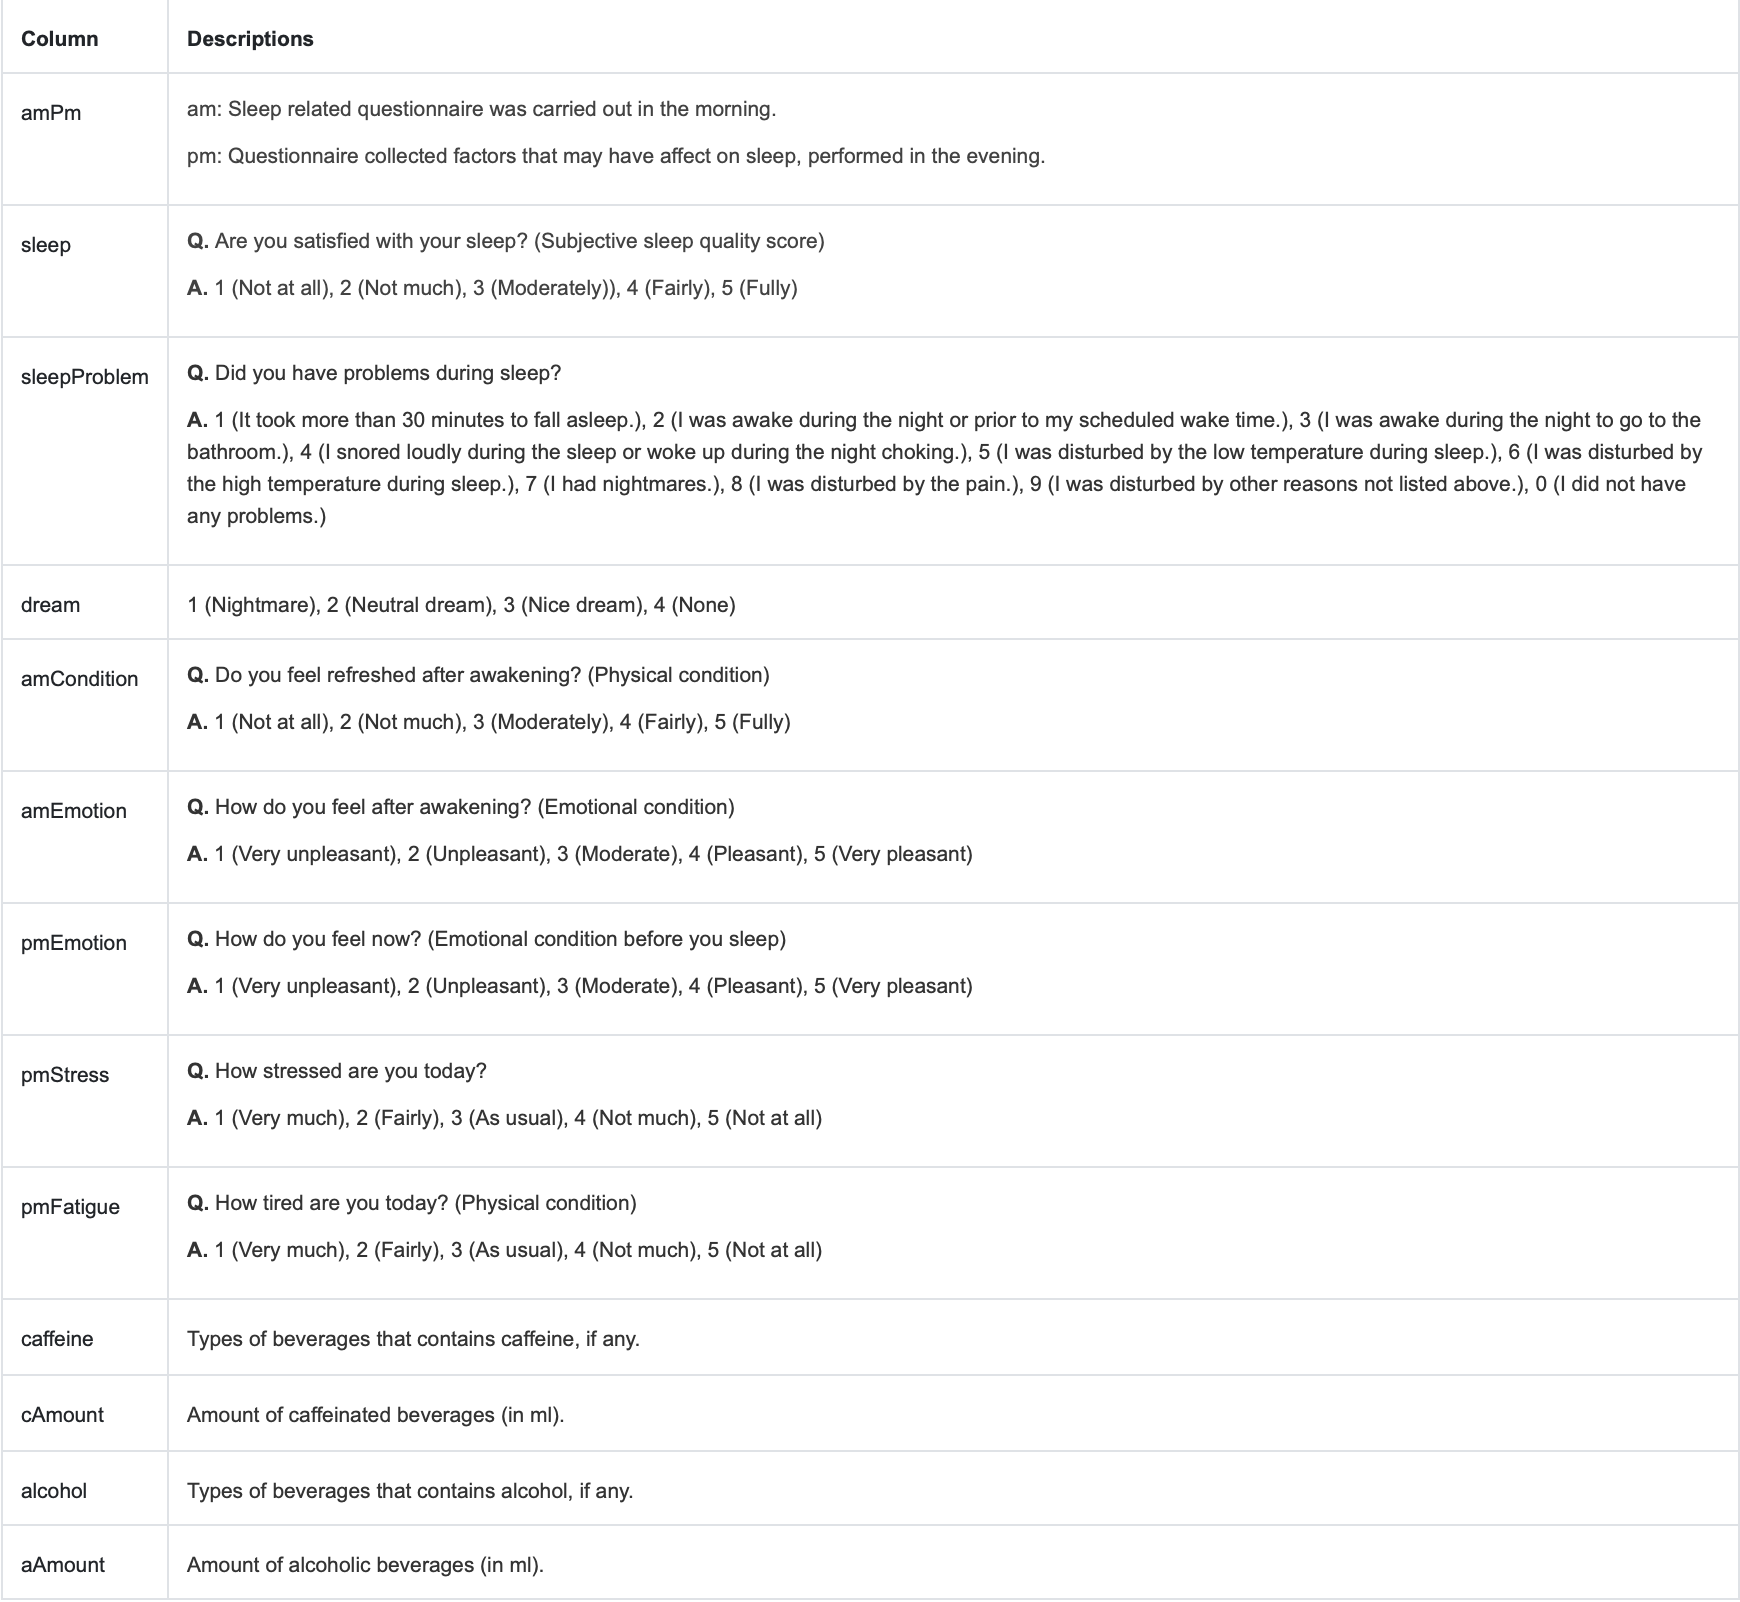

In [11]:
survey
# 아침 조사에서는 sleep quality, sleep problem, dream, amcondition, amemotion 등을 조사
# 저녁 조사에서는 pmEmotion, pmStress, pmFatigue, caffeine, cAmount, alchohol, aAmount 등을 조사
# 결국 저녁 때의 감정, 피곤도, 스트래스, 섭취 음료 등의 요인이 아침 조사 때의 숙면 퀄리티에 어떤 영향을 미치는 지 알아봐야 할듯

# survey[survey.alcohol.notna()]


,userId,date,amPm,startInput,endInput,sleep,sleepProblem,dream,amCondition,amEmotion,pmEmotion,pmStress,pmFatigue,caffeine,cAmount(ml),alcohol,aAmount(ml)
0,user24,2020-08-29,am,2020-08-29 21:23,2020-08-29 21:23,4.0,0.0,3.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,user24,2020-08-29,pm,2020-08-29 21:23,2020-08-29 21:23,NaN,NaN,NaN,NaN,NaN,4.0,4.0,2.0,NaN,NaN,NaN,NaN
2,user24,2020-08-30,am,2020-08-30 7:41,2020-08-30 7:41,3.0,2.0,2.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,user24,2020-08-30,pm,2020-08-30 22:43,2020-08-30 22:43,NaN,NaN,NaN,NaN,NaN,4.0,5.0,2.0,coffee,200.0,NaN,NaN
4,user24,2020-08-31,am,2020-08-31 7:23,2020-08-31 7:24,3.0,2.0,2.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,user06,2020-10-06,pm,2020-10-07 0:07,2020-10-07 0:08,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,NaN,NaN,NaN,NaN
1226,user06,2020-10-07,am,2020-10-07 8:02,2020-10-07 8:05,2.0,9.0,4.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1227,user06,2020-10-07,pm,2020-10-08 1:57,2020-10-08 1:57,NaN,NaN,NaN,NaN,NaN,5.0,2.0,3.0,coffee,250.0,NaN,NaN
1228,user06,2020-10-08,am,2020-10-08 8:23,2020-10-08 8:24,3.0,0.0,4.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### survey dataframe 하루치로 만들어주기
- 상관계수 보기 위해

In [12]:
survey_am = survey[survey.amPm == "am"]
survey_pm = survey[survey.amPm == "pm"]
result = pd.merge(survey_am, survey_pm, on=['userId', 'date'], how='inner')
result.drop(columns=['pmEmotion_x', 'pmStress_x', 'pmFatigue_x', 'caffeine_x', 'cAmount(ml)_x','alcohol_x','aAmount(ml)_x'], inplace=True)
result.drop(columns=['sleep_y', 'sleepProblem_y', 'dream_y', 'amCondition_y', 'amEmotion_y'], inplace=True)
result.drop(columns=['startInput_x', 'endInput_x', 'startInput_y', 'endInput_y'], inplace=True)

### null값 0으로 채우고 카페인 종류 one-hot encoding

In [13]:
# nan값을 모두 0으로 바꾸기 - 여기서 nan은 안먹었다는 의미이기 때문
result.fillna(0, inplace=True)

In [14]:
result.caffeine_y.unique() # 원핫 인코딩

array([0, 'coffee', 'tea', 'caffeinated drink', 'coke'], dtype=object)

In [15]:
temp = pd.get_dummies(result[['caffeine_y']])

In [16]:
result.drop(columns=['caffeine_y'], inplace=True)
new_result = pd.concat([result, temp], axis=1) # 기존의 df와 원핫인코딩 된 df 합쳐줌

### 날짜별 survey 데이터프레임

In [17]:
new_result

,userId,date,amPm_x,sleep_x,sleepProblem_x,dream_x,amCondition_x,amEmotion_x,amPm_y,pmEmotion_y,pmStress_y,pmFatigue_y,cAmount(ml)_y,alcohol_y,aAmount(ml)_y,caffeine_y_0,caffeine_y_caffeinated drink,caffeine_y_coffee,caffeine_y_coke,caffeine_y_tea
0,user24,2020-08-29,am,4.0,0.0,3.0,3.0,4.0,pm,4.0,4.0,2.0,0.0,0,0.0,True,False,False,False,False
1,user24,2020-08-30,am,3.0,2.0,2.0,2.0,3.0,pm,4.0,5.0,2.0,200.0,0,0.0,False,False,True,False,False
2,user24,2020-08-31,am,3.0,2.0,2.0,3.0,3.0,pm,4.0,2.0,4.0,200.0,0,0.0,False,False,True,False,False
3,user24,2020-09-01,am,4.0,0.0,4.0,4.0,3.0,pm,5.0,4.0,3.0,150.0,0,0.0,False,False,True,False,False
4,user24,2020-09-02,am,4.0,0.0,4.0,2.0,4.0,pm,4.0,4.0,2.0,0.0,0,0.0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,user06,2020-10-04,am,4.0,0.0,4.0,4.0,4.0,pm,3.0,2.0,3.0,0.0,0,0.0,True,False,False,False,False
611,user06,2020-10-05,am,4.0,0.0,4.0,4.0,3.0,pm,4.0,4.0,4.0,0.0,0,0.0,True,False,False,False,False
612,user06,2020-10-06,am,4.0,0.0,4.0,4.0,4.0,pm,4.0,4.0,4.0,0.0,0,0.0,True,False,False,False,False
613,user06,2020-10-07,am,2.0,9.0,4.0,2.0,3.0,pm,5.0,2.0,3.0,250.0,0,0.0,False,False,True,False,False


In [18]:
new_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   userId                        615 non-null    object 
 1   date                          615 non-null    object 
 2   amPm_x                        615 non-null    object 
 3   sleep_x                       615 non-null    float64
 4   sleepProblem_x                615 non-null    float64
 5   dream_x                       615 non-null    float64
 6   amCondition_x                 615 non-null    float64
 7   amEmotion_x                   615 non-null    float64
 8   amPm_y                        615 non-null    object 
 9   pmEmotion_y                   615 non-null    float64
 10  pmStress_y                    615 non-null    float64
 11  pmFatigue_y                   615 non-null    float64
 12  cAmount(ml)_y                 615 non-null    float64
 13  alcoh

In [19]:
new_result_num = new_result.select_dtypes(include=['number', 'bool']) # 종속변수에 영향 많이 미치는 변수 알아내기(상관계수 파악)
new_result_num.corr()

,sleep_x,sleepProblem_x,dream_x,amCondition_x,amEmotion_x,pmEmotion_y,pmStress_y,pmFatigue_y,cAmount(ml)_y,aAmount(ml)_y,caffeine_y_0,caffeine_y_caffeinated drink,caffeine_y_coffee,caffeine_y_coke,caffeine_y_tea
sleep_x,1.000000,-0.216194,-0.009996,0.476218,0.389353,0.114462,1.160259e-02,0.161913,-0.087101,-0.055793,0.004905,-0.086312,0.014479,2.040515e-02,0.041390
sleepProblem_x,-0.216194,1.000000,-0.229097,-0.143639,-0.147748,0.131358,4.364061e-02,-0.054690,0.015829,0.073338,-0.019342,0.057178,0.000434,1.865044e-02,-0.021315
dream_x,-0.009996,-0.229097,1.000000,0.031787,-0.021358,-0.091504,-3.844522e-02,-0.022632,0.002987,-0.097617,0.004664,0.026953,0.000046,-6.203727e-02,-0.023673
amCondition_x,0.476218,-0.143639,0.031787,1.000000,0.666677,0.160782,1.992514e-01,0.340290,-0.140206,-0.025539,0.130877,-0.055952,-0.121833,-1.290768e-02,0.066080
amEmotion_x,0.389353,-0.147748,-0.021358,0.666677,1.000000,0.214980,2.175093e-01,0.332811,-0.145939,-0.003063,0.192292,-0.077845,-0.165989,-2.855974e-02,0.017723
pmEmotion_y,0.114462,0.131358,-0.091504,0.160782,0.214980,1.000000,4.652266e-01,0.310622,-0.093508,0.047446,0.053553,-0.017798,-0.052835,-8.293223e-03,0.037656
pmStress_y,0.011603,0.043641,-0.038445,0.199251,0.217509,0.465227,1.000000e+00,0.385327,-0.179449,0.083613,0.140281,-0.041469,-0.138965,1.071288e-16,0.069564
pmFatigue_y,0.161913,-0.054690,-0.022632,0.340290,0.332811,0.310622,3.853275e-01,1.000000,-0.118248,-0.025479,0.083394,0.000347,-0.097984,4.305471e-03,0.078893
cAmount(ml)_y,-0.087101,0.015829,0.002987,-0.140206,-0.145939,-0.093508,-1.794490e-01,-0.118248,1.000000,-0.011163,-0.762204,0.100998,0.733390,2.067839e-02,-0.005132
aAmount(ml)_y,-0.055793,0.073338,-0.097617,-0.025539,-0.003063,0.047446,8.361285e-02,-0.025479,-0.011163,1.000000,0.033359,-0.036497,-0.017353,-1.700675e-02,-0.006832


In [21]:
new_result['alcohol_y'] = new_result['alcohol_y'].astype(str)
new_result.to_csv('./data/new_survey.csv', index=False)

## ★user_info(키, 성별, 몸무게, 나이)
- 성별, 나이, 키 등의 정보가 과연 수면의 질과 연관성을 가질까..?

In [22]:
user_info

,userId,gender,age,handed,height,weight,startDt,endDt
0,user24,F,26,Right,165,67,2020-08-29,2020-09-27
1,user23,M,35,Right,177,84,2020-08-31,2020-09-27
2,user05,M,31,Right,177,75,2020-08-31,2020-09-27
3,user04,M,28,Right,171,70,2020-08-31,2020-09-27
4,user12,F,30,Right,160,54,2020-08-30,2020-09-27
5,user08,M,32,Right,180,84,2020-08-31,2020-09-25
6,user02,F,25,Left,168,81,2020-08-31,2020-09-27
7,user10,M,25,Right,184,77,2020-08-30,2020-09-27
8,user03,F,32,Right,166,62,2020-08-29,2020-09-27
9,user11,M,32,Right,175,78,2020-08-30,2020-09-27


In [23]:
user_info.drop(columns = ['startDt', 'endDt'], inplace = True) # 시작, 끝 날짜 안중요 -> 삭제

### 인적 정보와 survey결과 합치기

In [25]:
survey_and_user_info = pd.merge(user_info, new_result, on=['userId'], how='inner')
survey_and_user_info['alcohol_y'] = survey_and_user_info['alcohol_y'].astype(str)
survey_and_user_info.to_csv("./data/survey_and_userinfo.csv", index=False)

## ★Mat columns
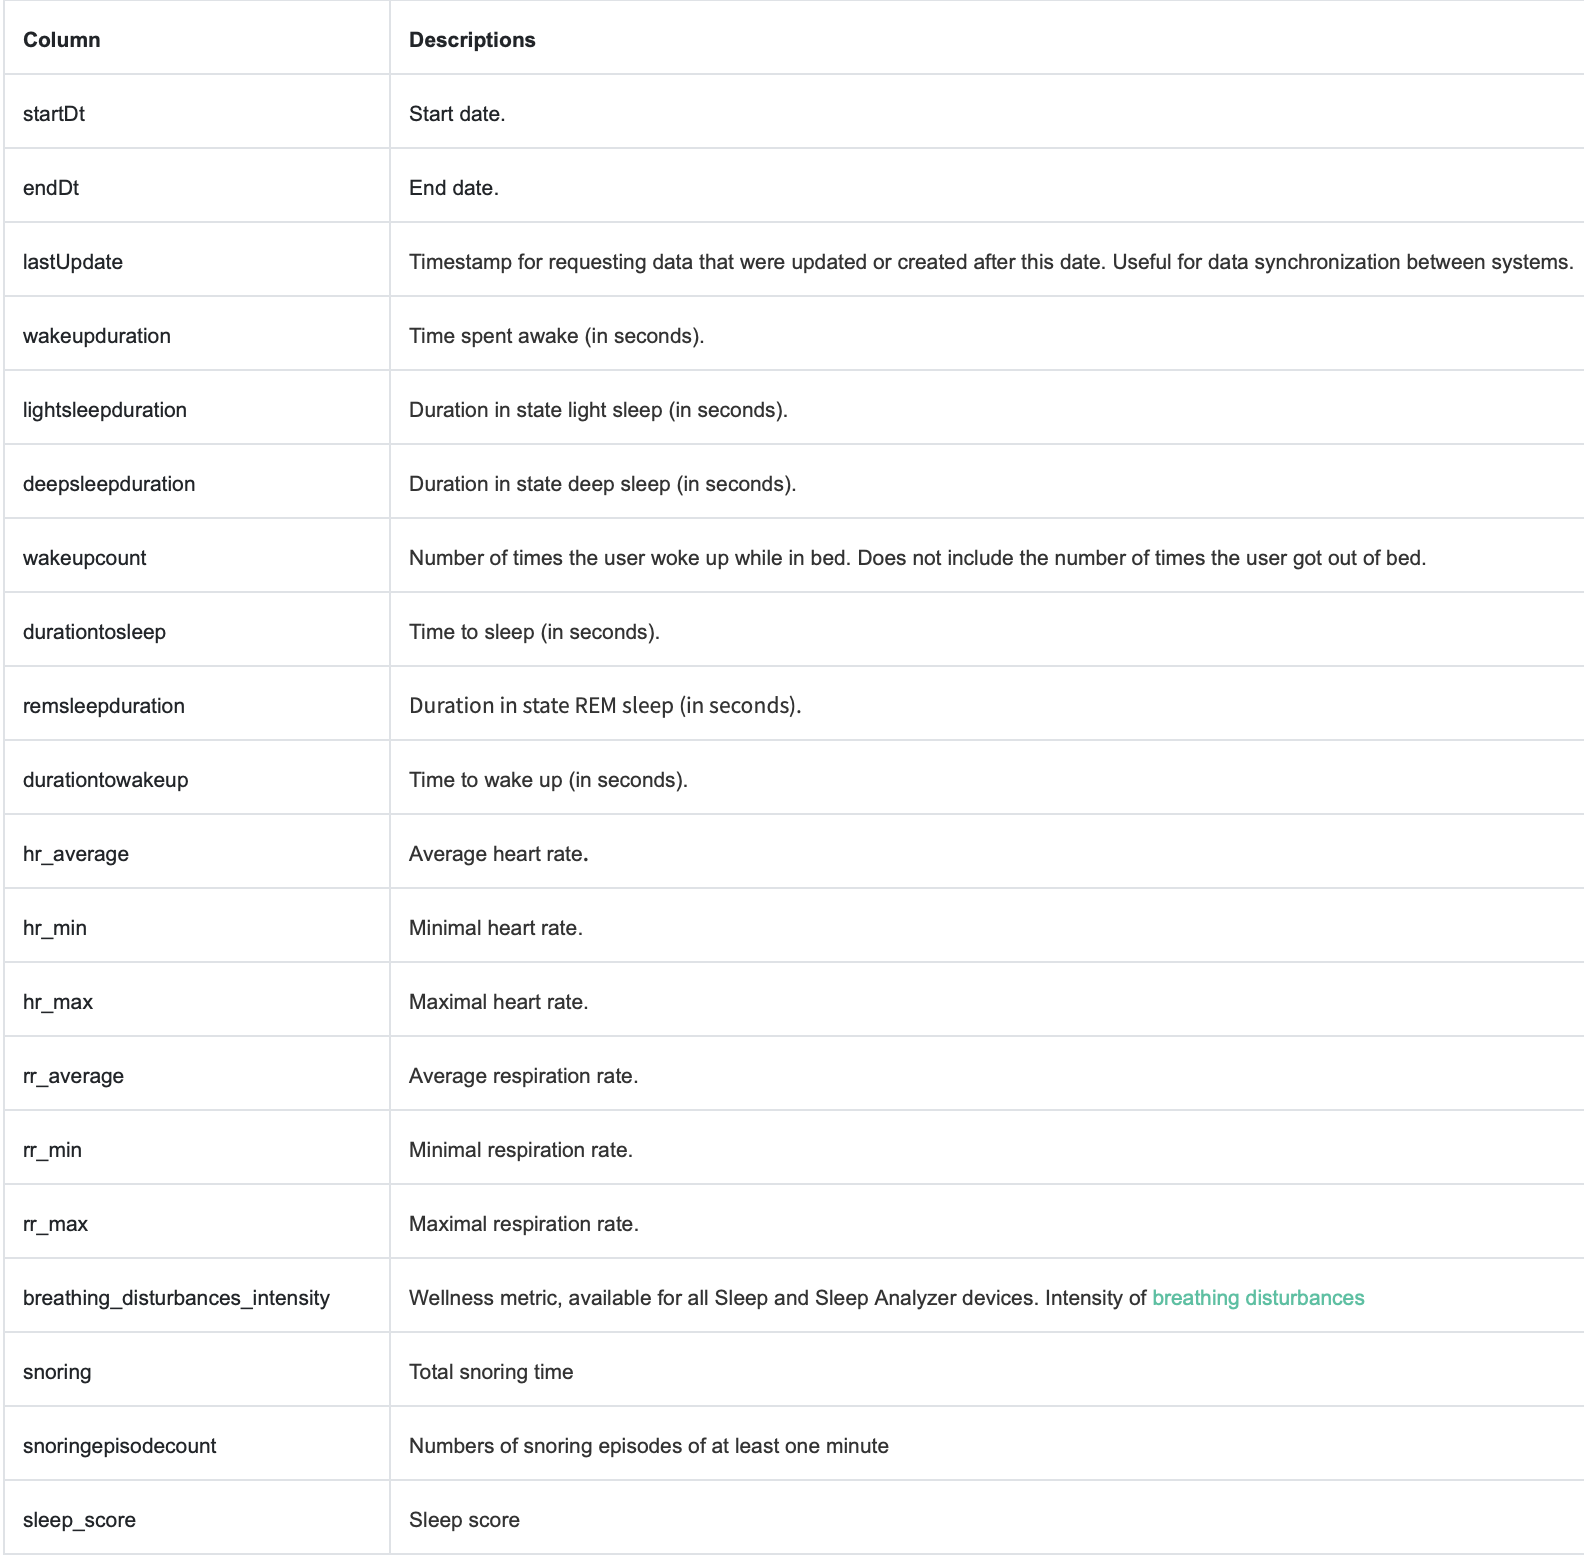

-----


In [26]:
mat


,userId,timezone,date,startDt,endDt,lastUpdate,wakeupduration,lightsleepduration,deepsleepduration,wakeupcount,durationtosleep,remsleepduration,durationtowakeup,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user24,Asia/Seoul,2020-08-30,1598708760,1598740860,1598748252,3840,13800,9000,3,1740,5280,0,72,63,82,15,10,20,10,840,1,86
1,user24,Asia/Seoul,2020-08-31,1598800140,1598825940,1598833333,4740,9540,6360,1,3180,4980,600,69,60,82,15,11,20,8,2700,3,52
2,user24,Asia/Seoul,2020-09-01,1598885940,1598908800,1598916190,1920,8760,4740,1,1440,7440,0,70,58,94,15,12,23,8,0,0,61
3,user24,Asia/Seoul,2020-09-02,1598979420,1598999580,1599006969,2760,7740,7440,1,1380,2220,0,68,60,80,15,12,19,-1,240,1,40
4,user24,Asia/Seoul,2020-09-03,1599060780,1599085980,1599093370,3900,11640,7620,1,1680,2040,600,71,61,83,15,11,25,7,300,1,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,user06,Asia/Seoul,2020-10-05,1601831040,1601861820,1601862001,8460,11820,4560,1,7740,5940,0,48,43,81,17,12,22,13,2400,5,60
611,user06,Asia/Seoul,2020-10-06,1601923560,1601951220,1601951380,1920,13200,7500,1,1320,4680,600,52,47,84,17,10,23,10,1380,4,79
612,user06,Asia/Seoul,2020-10-07,1602001320,1602023760,1602031150,12420,8520,1500,3,10440,0,0,47,42,76,16,12,20,-1,1620,4,20
613,user06,Asia/Seoul,2020-10-08,1602091020,1602110280,1602117673,4380,9240,4560,2,2820,1080,0,52,47,68,17,10,20,-1,2280,2,20


In [27]:
mat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   userId                            615 non-null    object
 1   timezone                          615 non-null    object
 2   date                              615 non-null    object
 3   startDt                           615 non-null    int64 
 4   endDt                             615 non-null    int64 
 5   lastUpdate                        615 non-null    int64 
 6   wakeupduration                    615 non-null    int64 
 7   lightsleepduration                615 non-null    int64 
 8   deepsleepduration                 615 non-null    int64 
 9   wakeupcount                       615 non-null    int64 
 10  durationtosleep                   615 non-null    int64 
 11  remsleepduration                  615 non-null    int64 
 12  durationtowakeup      

### Mat df의 상관계수
- lightsleepduration, deepsleepduration, remsleepduration, hr_max, rr_max, breating_disturbances_intensity, snoring, snoringepisodecount은 강한 **양의 상관관계**
- hr_min, rr_min은 **음의 상관관계** 가짐

In [28]:
numeric_df = mat.select_dtypes(include=[np.number])
corr = numeric_df.corr()
corr[abs(corr) >= 0.1].sleep_score

startDt                                  NaN
endDt                                    NaN
lastUpdate                               NaN
wakeupduration                           NaN
lightsleepduration                  0.633229
deepsleepduration                   0.528070
wakeupcount                              NaN
durationtosleep                          NaN
remsleepduration                    0.784069
durationtowakeup                         NaN
hr_average                               NaN
hr_min                             -0.195264
hr_max                              0.193506
rr_average                               NaN
rr_min                             -0.323381
rr_max                              0.332759
breathing_disturbances_intensity    0.381432
snoring                             0.276881
snoringepisodecount                 0.266396
sleep_score                         1.000000
Name: sleep_score, dtype: float64

### 서베이, 유저 정보, mat 관련 데이터 프레임 합침
- 그러나 inner로 합치니까 615 -> 585로 개수 줄어듬
- userid, date로 inner하였는데 서베이의 date 종류는 41개, mat의 date 종류는 50개였음
- 일단 right로 merge해서 데이터 개수 615로 맞춤

In [30]:

print(new_result['date'].nunique())
print(mat['date'].nunique()) # mat과 survey에는 다른 날짜 포함

mat_user = pd.merge(user_info, mat, on=['userId'], how='inner')

total = pd.merge(survey_and_user_info, mat_user, on=['userId', 'date'], how='right')
total = total.drop(['gender_y',	'age_y','handed_y',	'height_y',	'weight_y'], axis=1)
total = total.rename(columns={'gender_x': 'gender','age_x': 'age','handed_x': 'handed','height_x': 'height','weight_x': 'weight'})
total['alcohol_y'] = total['alcohol_y'].astype(str)
total.to_csv("./data/total.csv", index=False)

41
50


## Metrix to be identified
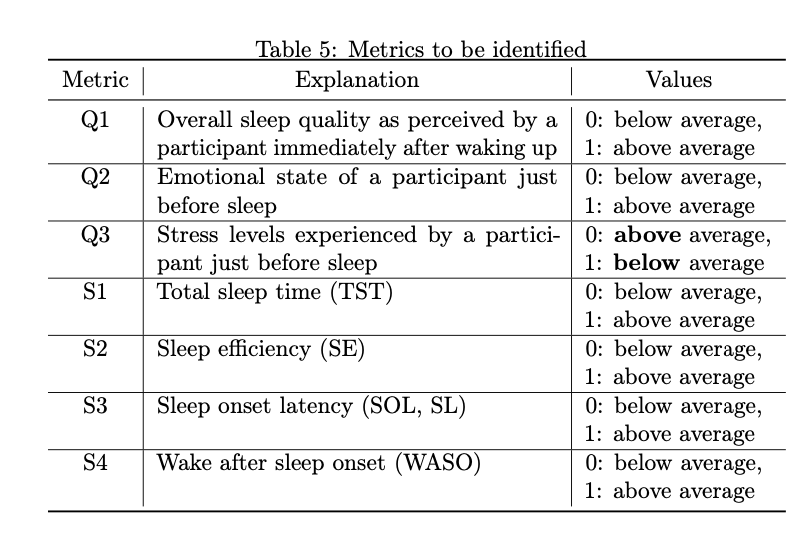

- Sleep onset latency는 "수면 시작 지연" 또는 "잠드는 데 걸리는 시간"을 의미합니다.
- WASO 값은 수면 중에 자주 깨어나는 것을 나타낼 수 있으며, 이는 수면의 질이 떨어지거나 수면 장애를 의미할 수 있습니다.



- 신생아의 적정 수면 시간은 14-17시간, 유아는 12-15시간, 걸음마기 아이는 11-14시간, 유치원 아이는 10-13시간, 그리고 학령기 아이는 9-11시간이라고 동의했습니다. 청소년의 경우 적정 수면 시간은 8-10시간, 젊은 성인과 성인은 7-9시간, 그리고 노년층의 경우 7-시간


In [31]:
total[total.userId == "user24"]

,userId,gender,age,handed,height,weight,date,amPm_x,sleep_x,sleepProblem_x,dream_x,amCondition_x,amEmotion_x,amPm_y,pmEmotion_y,pmStress_y,pmFatigue_y,cAmount(ml)_y,alcohol_y,aAmount(ml)_y,caffeine_y_0,caffeine_y_caffeinated drink,caffeine_y_coffee,caffeine_y_coke,caffeine_y_tea,timezone,startDt,endDt,lastUpdate,wakeupduration,lightsleepduration,deepsleepduration,wakeupcount,durationtosleep,remsleepduration,durationtowakeup,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user24,F,26.0,Right,165.0,67.0,2020-08-30,am,3.0,2.0,2.0,2.0,3.0,pm,4.0,5.0,2.0,200.0,0,0.0,False,False,True,False,False,Asia/Seoul,1598708760,1598740860,1598748252,3840,13800,9000,3,1740,5280,0,72,63,82,15,10,20,10,840,1,86
1,user24,F,26.0,Right,165.0,67.0,2020-08-31,am,3.0,2.0,2.0,3.0,3.0,pm,4.0,2.0,4.0,200.0,0,0.0,False,False,True,False,False,Asia/Seoul,1598800140,1598825940,1598833333,4740,9540,6360,1,3180,4980,600,69,60,82,15,11,20,8,2700,3,52
2,user24,F,26.0,Right,165.0,67.0,2020-09-01,am,4.0,0.0,4.0,4.0,3.0,pm,5.0,4.0,3.0,150.0,0,0.0,False,False,True,False,False,Asia/Seoul,1598885940,1598908800,1598916190,1920,8760,4740,1,1440,7440,0,70,58,94,15,12,23,8,0,0,61
3,user24,F,26.0,Right,165.0,67.0,2020-09-02,am,4.0,0.0,4.0,2.0,4.0,pm,4.0,4.0,2.0,0.0,0,0.0,True,False,False,False,False,Asia/Seoul,1598979420,1598999580,1599006969,2760,7740,7440,1,1380,2220,0,68,60,80,15,12,19,-1,240,1,40
4,user24,F,26.0,Right,165.0,67.0,2020-09-03,am,4.0,0.0,2.0,2.0,3.0,pm,3.0,2.0,2.0,200.0,0,0.0,False,False,True,False,False,Asia/Seoul,1599060780,1599085980,1599093370,3900,11640,7620,1,1680,2040,600,71,61,83,15,11,25,7,300,1,55
5,user24,F,26.0,Right,165.0,67.0,2020-09-04,am,3.0,0.0,2.0,2.0,3.0,pm,5.0,4.0,2.0,100.0,0,0.0,False,False,True,False,False,Asia/Seoul,1599144120,1599168060,1599175452,1140,10320,5520,0,1140,6960,0,67,59,83,15,10,23,7,1620,3,79
6,user24,F,26.0,Right,165.0,67.0,2020-09-05,am,4.0,0.0,3.0,3.0,5.0,pm,5.0,5.0,2.0,0.0,0,0.0,True,False,False,False,False,Asia/Seoul,1599247200,1599275280,1599282670,3780,9720,6480,1,3120,8100,0,67,59,78,15,11,30,9,4500,3,72
7,user24,F,26.0,Right,165.0,67.0,2020-09-06,am,4.0,0.0,2.0,2.0,3.0,pm,2.0,1.0,2.0,250.0,0,0.0,False,False,True,False,False,Asia/Seoul,1599319380,1599349080,1599356470,2700,11460,9000,2,1620,6540,0,68,58,80,15,9,21,9,1800,2,82
8,user24,F,26.0,Right,165.0,67.0,2020-09-07,am,4.0,1.0,2.0,4.0,3.0,pm,4.0,2.0,2.0,200.0,0,0.0,False,False,True,False,False,Asia/Seoul,1599409200,1599427200,1599434592,1020,4500,6120,0,1020,6360,0,71,60,94,16,12,26,-1,0,0,36
9,user24,F,26.0,Right,165.0,67.0,2020-09-08,am,4.0,0.0,4.0,1.0,4.0,pm,4.0,2.0,1.0,0.0,0,0.0,True,False,False,False,False,Asia/Seoul,1599496860,1599513600,1599520989,2580,4080,7020,1,1440,3060,0,66,50,78,15,12,18,-1,1260,2,20


In [56]:
train_label = pd.read_csv('./data/train_label.csv')
train_label

,Unnamed: 0,subject_id,date,Q1,Q2,Q3,S1,S2,S3,S4
0,0,user01,2020-08-30,1,0,0,1,1,0,0
1,1,user01,2020-08-31,0,0,0,0,1,1,1
2,2,user01,2020-09-01,0,0,0,0,1,1,1
3,3,user01,2020-09-02,1,0,0,1,1,1,1
4,4,user01,2020-09-03,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
503,503,user30,2020-09-21,0,0,1,0,1,0,0
504,504,user30,2020-09-22,0,0,1,0,1,1,1
505,505,user30,2020-09-23,0,0,1,0,1,1,0
506,506,user30,2020-09-24,1,0,1,0,1,1,1


In [62]:
total.rename(columns={'userId':'subject_id'}, inplace=True)
total.head()

,subject_id,gender,age,handed,height,weight,date,amPm_x,sleep_x,sleepProblem_x,dream_x,amCondition_x,amEmotion_x,amPm_y,pmEmotion_y,pmStress_y,pmFatigue_y,cAmount(ml)_y,alcohol_y,aAmount(ml)_y,caffeine_y_0,caffeine_y_caffeinated drink,caffeine_y_coffee,caffeine_y_coke,caffeine_y_tea,timezone,startDt,endDt,lastUpdate,wakeupduration,lightsleepduration,deepsleepduration,wakeupcount,durationtosleep,remsleepduration,durationtowakeup,hr_average,hr_min,hr_max,rr_average,rr_min,rr_max,breathing_disturbances_intensity,snoring,snoringepisodecount,sleep_score
0,user24,F,26.0,Right,165.0,67.0,2020-08-30,am,3.0,2.0,2.0,2.0,3.0,pm,4.0,5.0,2.0,200.0,0,0.0,False,False,True,False,False,Asia/Seoul,1598708760,1598740860,1598748252,3840,13800,9000,3,1740,5280,0,72,63,82,15,10,20,10,840,1,86
1,user24,F,26.0,Right,165.0,67.0,2020-08-31,am,3.0,2.0,2.0,3.0,3.0,pm,4.0,2.0,4.0,200.0,0,0.0,False,False,True,False,False,Asia/Seoul,1598800140,1598825940,1598833333,4740,9540,6360,1,3180,4980,600,69,60,82,15,11,20,8,2700,3,52
2,user24,F,26.0,Right,165.0,67.0,2020-09-01,am,4.0,0.0,4.0,4.0,3.0,pm,5.0,4.0,3.0,150.0,0,0.0,False,False,True,False,False,Asia/Seoul,1598885940,1598908800,1598916190,1920,8760,4740,1,1440,7440,0,70,58,94,15,12,23,8,0,0,61
3,user24,F,26.0,Right,165.0,67.0,2020-09-02,am,4.0,0.0,4.0,2.0,4.0,pm,4.0,4.0,2.0,0.0,0,0.0,True,False,False,False,False,Asia/Seoul,1598979420,1598999580,1599006969,2760,7740,7440,1,1380,2220,0,68,60,80,15,12,19,-1,240,1,40
4,user24,F,26.0,Right,165.0,67.0,2020-09-03,am,4.0,0.0,2.0,2.0,3.0,pm,3.0,2.0,2.0,200.0,0,0.0,False,False,True,False,False,Asia/Seoul,1599060780,1599085980,1599093370,3900,11640,7620,1,1680,2040,600,71,61,83,15,11,25,7,300,1,55


In [63]:
#train_label['subject_id']
total['subject_id']

0      user24
1      user24
2      user24
3      user24
4      user24
        ...  
610    user06
611    user06
612    user06
613    user06
614    user06
Name: subject_id, Length: 615, dtype: object

In [65]:
total1 = pd.merge(total, train_label, on=['subject_id', 'date'])
total1.to_csv('./data/total1.csv')